In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import matplotlib

In [2]:
warnings.simplefilter("ignore")

In [3]:
threshold = 2.25

## Second threshold of errors

In [4]:
hof = np.load("hof.npy", allow_pickle=True).tolist()

In [5]:
hof_to_keep = []

weights = { 'AP_amplitude':0.5, 'AP1_amp_rev':0.5, 'AP2_amp_rev':0.5, 'AHP_depth':2 }
for k in hof.keys():
    err = pd.Series(hof[k]['error'])
    
    # retune weights
    for wname, wvalue in weights.items():
        attrs = err.index[err.index.str.endswith(wname)]
        err[attrs] = err[attrs] / wvalue
        
    if err.abs().max() <= threshold:
        k = ('normal' if k[0].startswith('control') else '6ohda', k[1], k[2])
        # throw it
        hof_to_keep.append(k)

# Experimental data preparation

In [6]:
# read the efeatures and retained only the neurons selected during the preliminary quality checks
experiment_df = pd.read_csv('preprocessed_data_efeatures_selection.csv')

In [7]:
# reduce the attributes to the AP counts
experiment_df = experiment_df[['state',  'step current', 'stim dur', 'protocol', 
                               'AP_count', 'AP_count_before_stim', 'AP_count_after_stim']]

In [8]:
# rename columns
experiment_df.rename(columns={'stim dur':'duration', 'step current':'amplitude'}, inplace=True)

In [9]:
# rename state
experiment_df['state'].replace({'control':'normal'}, inplace=True)

In [10]:
# we are not interested 
# boundaries
experiment_df = pd.concat([
    experiment_df[(experiment_df['protocol'] == 'fi') & experiment_df['amplitude'].between(0, 300)],
    experiment_df[(experiment_df['protocol'] == 'rmih') & experiment_df['amplitude'].between(-200, -50)],
    experiment_df[(experiment_df['protocol'] == 'tburst') & (experiment_df['duration'] == 2000) & experiment_df['amplitude'].between(-300, -100)]
])

<AxesSubplot:xlabel='amplitude', ylabel='AP_count'>

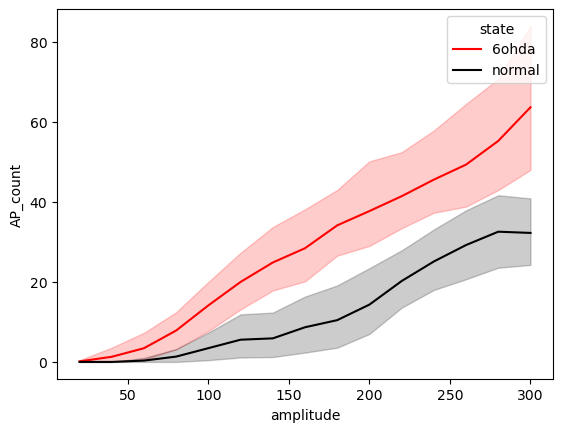

In [11]:
sns.lineplot(data=experiment_df[experiment_df['protocol'] == 'fi'], x='amplitude', y='AP_count', hue='state', palette=['red', 'black'])

<AxesSubplot:xlabel='amplitude', ylabel='AP_count_after_stim'>

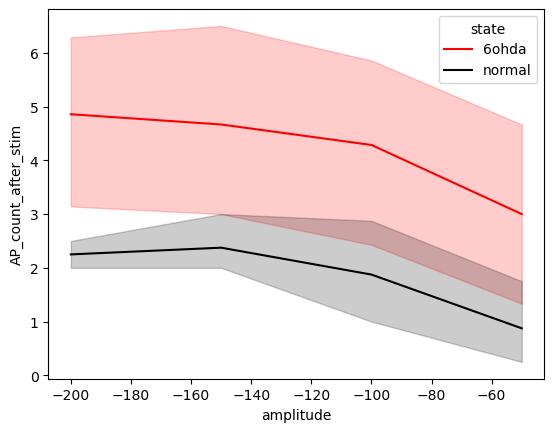

In [12]:
sns.lineplot(data=experiment_df[experiment_df['protocol'] == 'rmih'], x='amplitude', y='AP_count_after_stim', hue='state', palette=['red', 'black'])

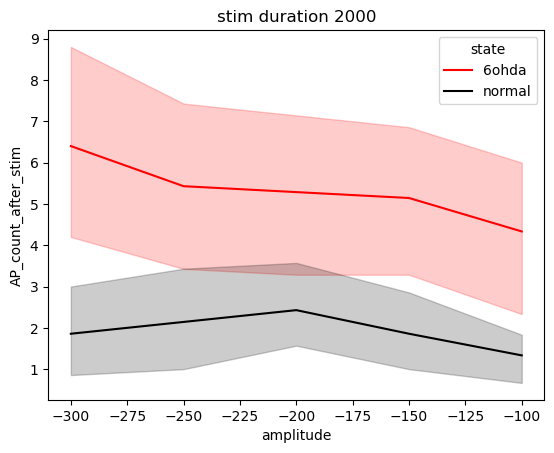

In [13]:
for dur in [2000]:
    plt.title('stim duration ' + str(dur))
    sns.lineplot(data=experiment_df[(experiment_df['protocol'] == 'tburst') & (experiment_df['duration'] == dur)], x='amplitude', y='AP_count_after_stim', hue='state', palette=['red', 'black'])
    plt.show()

# Simulation data preparation

In [14]:
df = pd.read_csv('qc_normal.csv')

In [15]:
df[['cellid', 'seed', 'state']].drop_duplicates()['state'].value_counts()

6ohda     334
normal    282
Name: state, dtype: int64

In [16]:
df.shape

(22792, 13)

In [17]:
# filter hof
df = df.set_index(['state', 'cellid', 'seed']).loc[hof_to_keep, :].reset_index()

In [18]:
df[['cellid', 'seed', 'state']].drop_duplicates()['state'].value_counts()

normal    40
6ohda     24
Name: state, dtype: int64

## Comparing curves for hyperpolarizing and depolarizing current steps

In [19]:
y_variable = {'fi':'AP_count', 'tburst':'AP_count_after_stim', 'rmih':'AP_count_after_stim' }

for _state in df['state'].unique():
    for _protocol, _y_variable in y_variable.items():
        # estimate the experimental curves
        exp_curve = experiment_df[(experiment_df['state']==_state)&(experiment_df['protocol']==_protocol)]
        exp_curve = exp_curve.groupby(['amplitude', 'duration'])[_y_variable].describe()[['count', 'mean', 'std']]
        exp_curve.dropna(inplace=True)

        # go over the simulated curves
        for k, g in df[(df['state']==_state)&(df['protocol']==_protocol)].groupby(['cellid', 'seed']):
            sim_curve = g.groupby(['amplitude', 'duration'])[_y_variable].describe()[['mean']]
            sim_curve.dropna(inplace=True)
            
            # only cases shown in the experiments
            sim_curve = sim_curve.loc[exp_curve.index, :]

            # max abs z-score
            max_err = ((sim_curve['mean'] - exp_curve['mean']) / (exp_curve['std'] + 0.001)).abs().max()

            if max_err > threshold:
                # remove if exceeding the threshold
                k += (_state, )

                df.drop(df[(df[['cellid', 'seed', 'state']]==k).all(axis=1)].index, inplace=True)

In [20]:
df[['cellid', 'seed', 'state']].drop_duplicates()['state'].value_counts()

6ohda     24
normal    17
Name: state, dtype: int64

## Comparing curves for depolarizing current steps with and without $K_M$

## Retuning bias current

In [21]:
pd.read_csv('qc_no_km_40.csv').groupby(['state', 'protocol']).voltage_base.describe()[['mean', 'std']]

mean       std
state  protocol                     
6ohda  fi       -69.367770  1.782618
       rmih     -72.902281  1.677773
       tburst   -69.370267  1.782575
normal fi       -68.038573  3.177506
       rmih     -73.900334  2.272676
       tburst   -68.041034  3.177421

In [22]:
pd.read_csv('qc_no_km_50.csv').groupby(['state', 'protocol']).voltage_base.describe()[['mean', 'std']]

mean       std
state  protocol                     
6ohda  fi       -68.556834  1.889640
       rmih     -72.902248  1.677789
       tburst   -68.559331  1.889594
normal fi       -66.415150  3.737061
       rmih     -73.900340  2.272680
       tburst   -66.417612  3.736976

In [23]:
pd.read_csv('qc_no_km_60.csv').groupby(['state', 'protocol']).voltage_base.describe()[['mean', 'std']]

mean       std
state  protocol                     
6ohda  fi       -67.630795  2.053312
       rmih     -72.902301  1.677762
       tburst   -67.633292  2.053262
normal fi       -64.654253  4.177995
       rmih     -73.900334  2.272678
       tburst   -64.656712  4.177915

* 60% of bias current for 6ohda
* 40% of bias current for control

In [24]:
df_no_km_40 = pd.read_csv('qc_no_km_40.csv')
df_no_km_60 = pd.read_csv('qc_no_km_60.csv')

df_no_km = pd.concat([
    df_no_km_40.loc[df_no_km_40.etype.str.startswith('control'), :],
    df_no_km_60.loc[df_no_km_60.etype.str.startswith('lesioned'), :]
])

## Remove individuals that fires spontaneously after $K_M$ blockade

In [25]:
df.set_index(['etype', 'cellid', 'seed'], inplace=True)
df_no_km.set_index(['etype', 'cellid', 'seed'], inplace=True)

In [26]:
# select neurons
df_no_km = df_no_km.loc[df.index, :]

In [27]:
df_no_km.shape

(56129, 10)

In [28]:
df.groupby(['state', 'protocol']).voltage_base.describe()[['mean', 'std']]

mean       std
state  protocol                     
6ohda  fi       -67.328064  0.720933
       rmih     -73.343604  1.089377
       tburst   -67.330607  0.720790
normal fi       -68.304627  0.610337
       rmih     -76.182299  1.265150
       tburst   -68.307123  0.610152

In [29]:
df_no_km.groupby(['state', 'protocol']).voltage_base.describe()[['mean', 'std']]

mean       std
state  protocol                     
6ohda  fi       -67.154639  1.260955
       rmih     -71.936933  1.189059
       tburst   -67.157184  1.260940
normal fi       -67.861355  1.643538
       rmih     -73.531218  1.599569
       tburst   -67.863858  1.643560

In [30]:
# remove neurons that fires spontaneously after KM blockade
df_no_km.drop(df_no_km.loc[df_no_km['AP_count_before_stim'] > 0].index.drop_duplicates(), inplace=True)

In [31]:
# select neurons
df = df.loc[df_no_km.index.drop_duplicates(), :]

In [32]:
df.reset_index(inplace=True)
df_no_km.reset_index(inplace=True)

In [33]:
df[['cellid', 'seed', 'state']].drop_duplicates()['state'].value_counts()

6ohda     24
normal    17
Name: state, dtype: int64

## Compare f-I curves between control and after $K_M$ blockade

In [34]:
# calculate the f-I curves for experiments
sim_curve = df[df['protocol']=='fi'].groupby(['state', 'amplitude', 'duration', 'cellid', 'seed'])[['AP_count']].mean().reset_index().set_index(['cellid', 'seed', 'state'])
sim_curve_no_km = df_no_km[df_no_km['protocol']=='fi'].groupby(['state', 'amplitude', 'duration', 'cellid', 'seed'])[['AP_count']].mean().reset_index().set_index(['cellid', 'seed', 'state'])

In [35]:
alpha_accept = 0.01 # p value threshold
alpha_reject = 0.01

for k in sim_curve.index.drop_duplicates():
    # select curve for one neuron
    _sim_curve = sim_curve.loc[k, :].reset_index()[['amplitude', 'AP_count']].sort_values(by='amplitude')
    _sim_curve_no_km = sim_curve_no_km.loc[k, :].reset_index()[['amplitude', 'AP_count']].sort_values(by='amplitude')
    
    # compare normal vs xe991 curves
    p = stats.ranksums(_sim_curve.to_numpy()[:, 1], _sim_curve_no_km.to_numpy()[:, 1] )[1]        

    if  (k[2] == 'normal' and p >= alpha_reject) or (k[2] == '6ohda' and p < alpha_accept):
        df.drop(df[(df[['cellid', 'seed', 'state']] == k).all(axis=1)].index, inplace=True)
        df_no_km.drop(df_no_km[(df_no_km[['cellid', 'seed', 'state']] == k).all(axis=1)].index, inplace=True)

In [36]:
df[['cellid', 'seed', 'state']].drop_duplicates()['state'].value_counts()

normal    17
6ohda     16
Name: state, dtype: int64

In [37]:
sim_curve = df[df['protocol']=='fi'].groupby(['state', 'amplitude'])[['AP_count']].mean().reset_index()
exp_curve = experiment_df[experiment_df['protocol']=='fi'].groupby(['state', 'amplitude'])[['AP_count']].mean().reset_index()

In [38]:
stats.ranksums(sim_curve[sim_curve.state == '6ohda'].to_numpy()[:, 2], exp_curve[exp_curve.state == '6ohda'].to_numpy()[:, 2] )[1]  

0.663185234258461

In [39]:
stats.ranksums(sim_curve[sim_curve.state == 'normal'].to_numpy()[:, 2], exp_curve[exp_curve.state == 'normal'].to_numpy()[:, 2] )[1]  

0.25401690678031386

# Save models to files

In [40]:
def filter_models(filename, id_list, fileout=None):
    good_models = {}
    for k, v in np.load(filename, allow_pickle=True).tolist().items():
       if k in id_list: 
         good_models.update({k:v})
        
    if fileout:
        np.save(fileout, good_models, allow_pickle=True)

In [41]:
filter_models("hof.npy", \
              df[['etype', 'cellid', 'seed']].drop_duplicates().set_index(['etype', 'cellid', 'seed']).index.tolist(), \
              fileout="hof_chk1.npy")